<a href="https://colab.research.google.com/github/alahkdmovak/Pronostico_aguacates/blob/main/Precio_aguacates_full_extra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
##**Pronóstico del precio del Aguacate**

Tratamiento de Señales III

**Facultad de Ingeniería**

**Universidad de Antioquia**

**Estudiantes:** Alahkdmovak Rúa Cardona - Harrison Andres Henao

In [48]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
from datetime import datetime, timedelta
import seaborn as sns

In [49]:
! pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Base de datos**

La base de datos se obtuvo de https://www.kaggle.com/datasets/neuromusic/avocado-prices, y en esta se encuentran el promedio de precios del aguacate que fueron tomados semanalmente durante algo mas de 3 años en distintas tiendas o mercados en el pais de Estados Unidos. También hay otras variables pero en este caso nos centraremos en las fechas y los precios del aguacate

In [50]:
!wget "https://raw.githubusercontent.com/alahkdmovak/Pronostico_aguacates/main/avocado.csv" -O "avocado.csv"

--2023-06-10 14:35:32--  https://raw.githubusercontent.com/alahkdmovak/Pronostico_aguacates/main/avocado.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1989197 (1.9M) [text/plain]
Saving to: ‘avocado.csv’

avocado.csv         100%[===================>]   1.90M  --.-KB/s    in 0.06s   

2023-06-10 14:35:33 (31.7 MB/s) - ‘avocado.csv’ saved [1989197/1989197]



In [51]:
df = pd.read_csv('avocado.csv')
df

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


##**Analisis y observación de la base de datos**

Se verifica el tipo de dato con el que se va a trabajar.

In [52]:
df = df.drop(['type','region'], axis=1)
df.dtypes

Unnamed: 0        int64
Date             object
AveragePrice    float64
Total Volume    float64
4046            float64
4225            float64
4770            float64
Total Bags      float64
Small Bags      float64
Large Bags      float64
XLarge Bags     float64
year              int64
dtype: object

El modelo Prophet necesita tener la columna temporal y el target(variable objetivo) con los nombres  'ds' e 'y' respectivamente, por lo que se cambian los nombres de estas en el dataframe.


Además se hace un casting a la columna Date para convertirla a formato datetime


In [53]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d') # Conversión a formato datetime
df.rename(columns={'Date':'ds', 'AveragePrice':'y'}, inplace=True)

Se verifica que no hayan datos nulos que puedan afectar el posterior tratamiento de la señal

In [54]:
df[df.isnull()].count()

Unnamed: 0      0
ds              0
y               0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
year            0
dtype: int64

In [55]:
#Se verifica si hay fechas duplicadas.
df[df.ds.duplicated()]['ds'].count()

18080

La anterior línea de código indica que si hay fechas duplicadas, esto es lógico ya que los datos son tomados semanalmente para diferentes mercados de estados unidos. En vista de esto, es necesario agrupar los datos por fecha.

In [56]:
grouped_df = df.groupby('ds').size().reset_index(name='count')
for _, row in grouped_df.iterrows():
    print('FECHA :', row['ds'], '  DATOS POR FECHA:', row['count'])

FECHA : 2015-01-04 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-01-11 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-01-18 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-01-25 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-02-01 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-02-08 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-02-15 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-02-22 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-03-01 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-03-08 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-03-15 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-03-22 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-03-29 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-04-05 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-04-12 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-04-19 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-04-26 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-05-03 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-05-10 00:00:00   DATOS POR FECHA: 108
FECHA : 2015-05-17 00:00:00   D

De la anterior celda se puede concluir que son 108 las tiendas de donde se recolectaron los datos.


#**Primer modelo a utilizar: Facebook Prophet**

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El paquete FB Prophet ha sido desarrollado tanto para R como para Python.


Facebook Prophet es un modelo muy extendido de pronóstico de series temporales, desarrollado por Facebook, es ampliamente utilizado en la comunidad para predecir datos secuenciales en el tiempo. Este paquete ha sido creado específicamente para facilitar el análisis y la predicción de series temporales.

**Ahora se exploraran los datos en busca de estacionalidades:**

 - Estacionalidad anual
 - Estacionalidad mensual
 - Estacionalidad semanal

In [57]:
print('Fecha inicio del histórico: ', df.ds.min())
print('Fecha fin del histórico: ', df.ds.max())
print('Número total de semanas: ', df.ds.nunique())

Fecha inicio del histórico:  2015-01-04 00:00:00
Fecha fin del histórico:  2018-03-25 00:00:00
Número total de semanas:  169


<ipython-input-58-8f87de12be03>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  por_años = por_años.groupby(['year', 'month']).sum().reset_index()


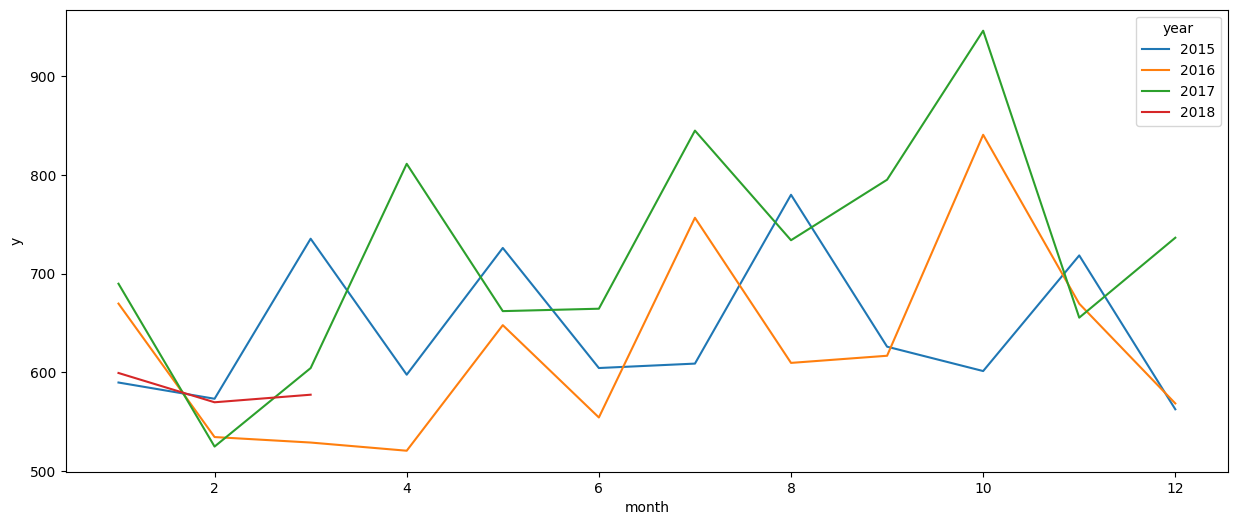

In [58]:
 # ESTACIONALIDAD ANUAL

por_años = df[['ds', 'y']].copy() 
por_años['year'] = por_años.ds.dt.year
por_años['month'] = por_años.ds.dt.month
por_años = por_años.groupby(['year', 'month']).sum().reset_index()

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=por_años, x='month', y='y', hue='year', ax=ax, palette= 'tab10')
plt.show()

- En la gráfica anterior observamos cierto patrón anual,se observa una tendencia creciente de año en año: a medida que aumenta el año, su gráfica, de color más oscuro, aumenta.
- Además, se observa que entre los meses de diciembre - Febrero el precio disminuye 


<ipython-input-59-056b2a0a0e56>:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  por_meses = por_meses.groupby(['month', 'week']).sum().reset_index()


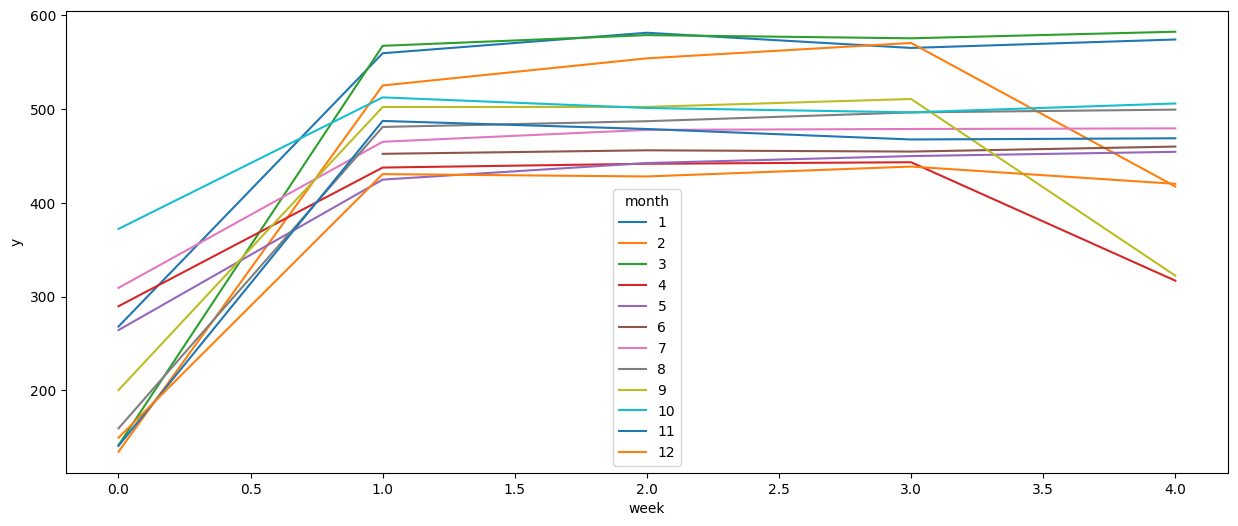

In [59]:
from math import ceil

# Función que devuelve la semana dentro del mes (de 1 a 4)
def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom - first_day.weekday()
    return int(ceil(adjusted_dom/7.0))

# ESTACIONALIDAD MENSUAL
por_meses = df[['ds', 'y']].copy()
por_meses['week'] = por_meses.ds.apply(week_of_month)
por_meses['month'] = por_meses.ds.dt.month
por_meses = por_meses.groupby(['month', 'week']).sum().reset_index()

fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.lineplot(data = por_meses,x = por_meses['week'],y= por_meses['y'], hue=por_meses['month'], ax=ax, palette= 'tab10')
plt.show()

agrupando por las semanas del mes se observa un patrón mensual. Esto nos dice que hay cierta estacionalidad mensual. En algunos meses los precios son más altos entre la primera y la tercera semana, en cambio en otros el precio es más alto entre la primera y la cuarta semana. La estacionalidad no es muy fuerte pero igual se tendrá en cuenta a la hora de entrenar el modelo.

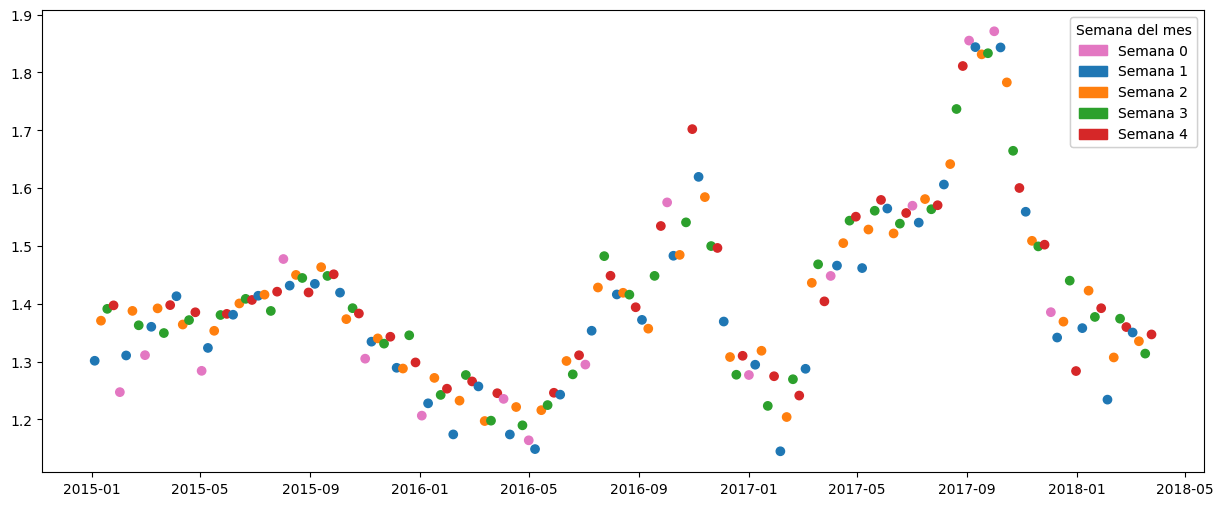

In [183]:
 # ESTACIONALIDAD SEMANAL

week_colors = { 0: 'tab:pink',1: 'tab:blue', 2: 'tab:orange', 3: 'tab:green', 4: 'tab:red'}

df_weekly = df.resample('W', on='ds').mean()  # Se crea un nuevo Dataframe agrupando las fechas repetidas en una sola y sacando la media del precio para estas fechas.
df_weekly.reset_index(inplace=True) 

plt.close()
fig, ax = plt.subplots(figsize=(15,6))
ax.scatter(df_weekly['ds'], df_weekly['y'], c=df_weekly.ds.apply(week_of_month).map(week_colors))
handles = [mpatches.Patch(color=v, label=f'Semana {k}') for k, v in week_colors.items()]
legend = ax.legend(handles=handles, bbox_to_anchor=(1, 1), title="Semana del mes")
ax.add_artist(legend)
plt.show()

- La estacionalidad semanal en este caso no tendría mucho sentido ya que las muestras se realizan semanalmente y por lo tanto no tiene porque repetirse (en ese caso el precio sería constante) como se observa en la gráfica.


- Esta es otra forma de también observar la estacionalidad mensual, cada color corresponde a una semana específica del mes. como se puede ver hay algunos meses en los que esa semana si tiene un precio similar pero hay otros en los que es totalmente diferente, dado esto se confirma que la estacionalidad mensual es pequeña por lo que no aportará mucho al modelo


- Se observa un cambio de tendencia en la fecha 2016-05, luego de esta los datos tienen una variabilidad mucho mayor. también se tomará en cuenta este dato para entrenar el modelo.


- En conclusión la estacionalidad más fuerte es la anual, más adelante se definen las estacionalidades y su peso en el modelo.

**Estacionalidades Condicionales:**

A continuación se definen las 2 estacionalidades que se lograron observar.
 - El antes y el después del 2016 - 05
 - La disminución de precios entre Diciembre - Febrero

Para cada una de ellas, Prophet pide que se definan dos columnas booleanas complementarias, una que esté a True cuando se cumple la condición y a False cuando no, y la otra que funcione al contrario.

Las condiciones son las siguientes:

In [184]:
#Estacionalidad del antes y el despues del 2016 - 05
df_weekly['año_2015'] = [True if dt < pd.to_datetime('2016-06-01') else False for dt in df_weekly['ds']]                      
df_weekly['año_2016_o_mas'] = [False if dt < pd.to_datetime('2016-06-01') else True for dt in df_weekly['ds']]

# Estacionalid de la disminución de precio
df_weekly['primeras_semanas'] = [True if (dt.week <= 12 ) else False for dt in df_weekly['ds']]
df_weekly['no_primeras_semanas'] = [False if (dt.week <= 12) else True for dt in df_weekly['ds']]

estacionalidades = ['año_2015', 'año_2016_o_mas', 'primeras_semanas', 'no_primeras_semanas']

**Nota:** Se trabaja sobre el dataframe df_weekly donde ya están agrupados los datos por fechas (se obtiene la media del precio en cada fecha). Esto se hace debido a que no se deben tener fechas repetidas para lograr un buen funcionamiento del modelo.

##**Regresores:**

In [338]:
# Regresores
regresores = [c for c in df_weekly.columns if c not in ['ds', 'y'] + estacionalidades]

# Descarta regresores nulos, constantes o de poca variación
def descartar_constantes(df, regresores, pct_std=0.01, pct_variacion=0.01):
    to_drop = []
    for v in regresores:
        if df[v].mean() == 0:
            if df[v].std() < pct_std:
                print("Media = 0, std < 0.01", v)
                to_drop.append(v)
        elif abs(df[v].std()/df[v].mean()) <= pct_variacion:
            print("Media!= 0, coef_var < 0.2", v, abs(df[v].std()/df[v].mean()))
            to_drop.append(v)
    return df.drop(columns=to_drop)

# Calcula la correlación de cada regresor con la variable objetivo
def calcular_importancias(df, regresores):
    importancias = dict()
    for r in regresores:
        corr = abs(df['y'].corr(df[r]))
        if corr is None:
            corr = 0.0
        importancias[r] = corr
    return importancias

# Descarta uno de cada dos regresores correlacionados entre ellos más de 0.79999.
def descartar_correladas_importancias(df, regresores, corr=0.79999):
    importancias = calcular_importancias(df, regresores)
    list_sorted = regresores.copy()
    list_sorted.sort(key=lambda val: importancias[val], reverse=True)
    dfc = df.reindex(list_sorted, axis=1)
    corr_matrix = dfc.corr().abs()
    corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool)).T
    corr_list = corr_matrix.unstack().reset_index()
    corr_list = corr_list.loc[corr_list[0]>corr]
    to_drop = set()
    for a, b in zip(corr_list['level_0'], corr_list['level_1']):
        if a not in to_drop:
            to_drop.add(b)
    return to_drop

# Simplificación de regresores
df_weekly = descartar_constantes(df_weekly, regresores)
regresores = [r for r in regresores if r in df_weekly.columns]
to_drop = descartar_correladas_importancias(df_weekly, regresores)
df_weekly.drop(columns=to_drop, inplace=True)
regresores = [r for r in regresores if r not in to_drop]

##**Entrenamiento del modelo:**
Prophet tiene algunas funciones principales para su entrenamiento, las que usaremos son:


- m = Prophet(params): esta acción guarda en m el objeto del modelo construido con los parámetros dados.


- m.add_seasonality(…): para añadir las estacionalidades manualmente.


- m.fit(df): la función que ajusta m a los datos que haya en df. Requiere como mínimo las columnas 'ds' e 'y'.


- fcst = m.predict(future): predicción hecha sobre las fechas futuras o el conjunto de Test.


**Parámetros:**


- growth: 'linear'
- changepoints: ['2016-05-15'] se añade un día como changepoint manualmente.
- yearly_seasonality: False (las estacionalidades se añadirán manualmente)
- weekly_seasonality: False
- daily_seasonality: False
- seasonality_mode: 'multiplicative' (puesto que se ve en las gráficas que con los años aumenta la dispersión. El efecto estacional es multiplicativo)




**Estacionalidades:**


Prophet permite añadir estacionalidades manualmente con la función add_seasonality, cuyos parámetros son:


- name: nombre de la estacionalidad
- period: periodo de la estacionalidad (por ejemplo 52 semanas para anual)
- fourier_order: orden para la suma de fourier que la aproxima. Valores típicos son:
10 o más para anual, nosotros le damos 30. 3 para semanal, en este caso como las estacionalidades semanales son condicionales,se varía el orden dando un poco más a las fechas en que se considera que la estacionalidad es más fuerte, y menos en el resto.
- prior_scale: Da la prioridad a los condicionales
- condition_name: nombre de la columna con la condición, para el caso de las estacionalidades condicionales.

In [365]:
from prophet import Prophet

params = {'growth': 'linear',
          'changepoints':['2016-05-15'],
          'yearly_seasonality': False, # se añaden manualmente
          'weekly_seasonality': False,
          'daily_seasonality': False,
          'seasonality_mode': 'multiplicative',
          'changepoint_prior_scale':0.024,
          'interval_width': 0.8,
          'uncertainty_samples': 10}


seasonalities = [{'name': 'yearly', 'period': 52, 'fourier_order':21}, #estacionalidad anual
                 {'name': 'antes_mayo_2016', 'period': 52, 'prior_scale':0.05, #estacionalidad condicional
                  'fourier_order':2, 'condition_name': 'año_2015'},
                 {'name': 'despues_mayo_2016', 'period': 52, 'prior_scale':1, 
                  'fourier_order':5, 'condition_name': 'año_2016_o_mas'},
                 {'name': 'first_weeks', 'period': 2, 'prior_scale':2,     #estacionalidad condicional
                  'fourier_order':4, 'condition_name': 'primeras_semanas'},
                 {'name': 'no_first_weeks', 'period': 4, 'prior_scale':1,
                  'fourier_order':1, 'condition_name': 'no_primeras_semanas'},
                 {'name': 'monthly', 'period': 4, 'fourier_order':2}]  #estacionalidad mensual

m = Prophet(**params)  #Se construye el modelo
for s in seasonalities:  # se añaden las estacionalidades
    m.add_seasonality(**s)

for r in regresores: # Se añaden los regresores
    m.add_regressor(r, mode='additive')

#índice de corte para la partición del dataframe
indice_corte = int(len(df_weekly) * 0.7)

# Particion el DataFrame
df_train = df_weekly.iloc[:indice_corte]
df_test = df_weekly.iloc[indice_corte:]

m.fit(df_train) # Entrenamiento del modelo
forecast_test = m.predict(df_test)
forecast_train = m.predict(df_train) # pronóstico del modelo

DEBUG:cmdstanpy:input tempfile: /tmp/tmpo_isrove/7__sxa37.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo_isrove/8lz7fqhf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93492', 'data', 'file=/tmp/tmpo_isrove/7__sxa37.json', 'init=/tmp/tmpo_isrove/8lz7fqhf.json', 'output', 'file=/tmp/tmpo_isrove/prophet_modelmlk_orwg/prophet_model-20230610155333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:53:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:53:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


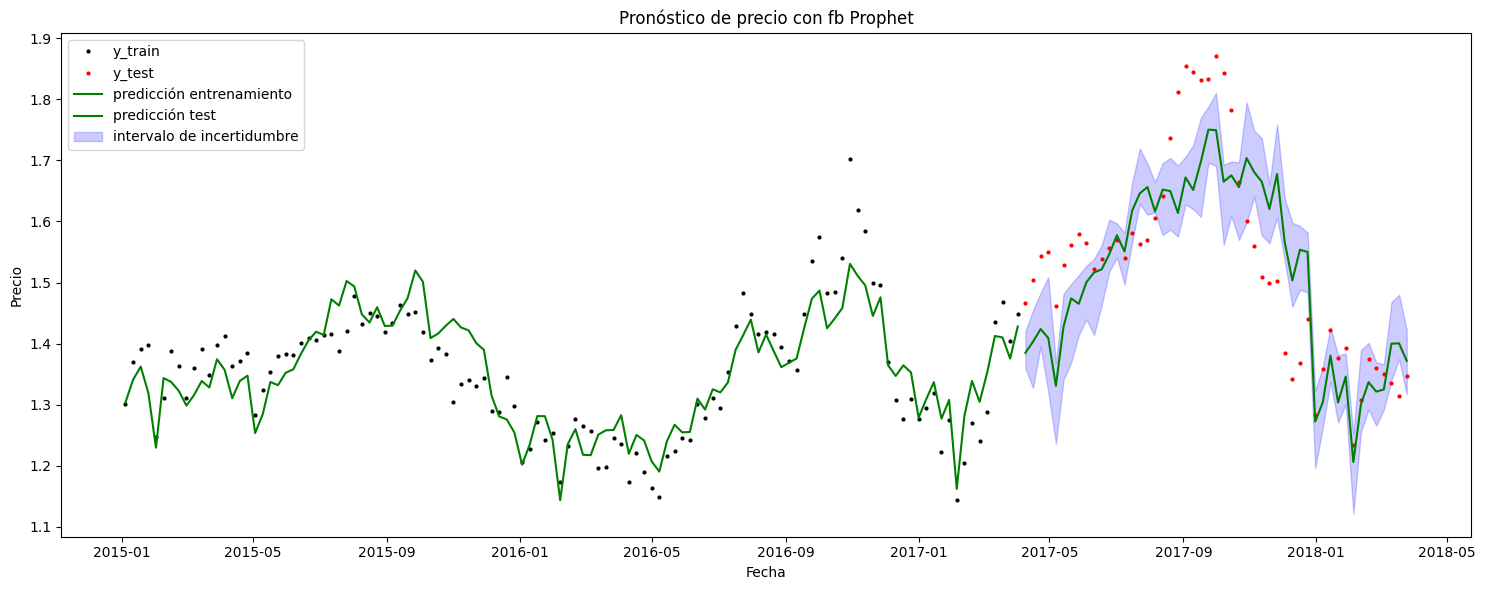

In [360]:
# Gráfica de la predicción

t = np.linspace(0,len(df_weekly)+1, len(df_weekly))
t1 = t[0:indice_corte]
t2 = t[indice_corte:]
plt.close()
legend = ['y_train', 'y_test', 'predicción entrenamiento', 'predicción test']

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(df_train['ds'], df_train['y'], c='black', marker='o', markersize=2, ls='')
ax.plot(df_test['ds'], df_test['y'], c='r', marker='o', markersize=2, ls='')
ax.plot(forecast_train['ds'],forecast_train['yhat'], ls='-', color='green', alpha=1)
ax.plot(forecast_test['ds'], forecast_test['yhat'], ls='-', color='green', alpha=1)
ax.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='b', alpha=0.2)
legend.append('intervalo de incertidumbre')
ax.legend(legend)
ax.set(title='Pronóstico de precio con fb Prophet', xlabel='Fecha', ylabel='Precio')
plt.tight_layout()
plt.show()

##**Medición del error**


Se utiliza el $\textit{MAPE}$  para medir el error final del modelo sobre el periodo de test.


El $\textit{MAPE}$ se expresa como un porcentaje, lo que lo hace fácilmente interpretable. Un valor de $\textit{MAPE}$ de 10 significa que, en promedio, el pronóstico difiere en un 10% de los valores reales. es más intuitivo que el $\textit{MSE}$, cuyo valor es la distancia cuadrada media entre la predicción y el dato real.


se acepta por bueno un $\textit{MAPE}$ por debajo del 20%.


Además, también se mide cómo de bien se ajusta nuestro modelo a la variabilidad de los datos con la métrica $R^2$. Toma valores de 0% a 100%, dándose por buenos los modelos que alcanzan un $R^2$ por encima del 70%.


In [361]:
from sklearn.metrics import r2_score

def MAPE(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    return np.mean([100*abs((actual[i]-forecast[i])/actual[i]) for i in range(len(actual))])

def metrics(df_train, forecast_train, df_test, forecast_test):
    MAPE_metric = pd.DataFrame(index=['MAPE'],
                               data={'Train': [MAPE(df_train['y'], forecast_train['yhat'])],
                                    'Test': [MAPE(df_test['y'], forecast_test['yhat'])]})
    r2_metric = pd.DataFrame(index=['R2'],
                             data={'Train': [100*r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])],
                                   'Test': [100*r2_score(y_true=df_test['y'], y_pred=forecast_test['yhat'])]})

    return pd.concat([MAPE_metric, r2_metric])

In [366]:
metrics(df_train, forecast_train, df_test, forecast_test)

,Train,Test
MAPE,2.751373,5.480605
R2,79.018371,62.337364


**Análisis del modelo:**


- EL resultado muy bueno por parte del  $\textit{MAPE}$.para el conjunto de test tiene un 8% aproximadamente, lo que indica que la predicción sólo difiere un 8% de los datos reales.


- Sin embargo, es importante evaluar si el $\textit{MAPE}$ del 8% es aceptable o si se necesita una mayor precisión para este tipo de aplicaciones (muy posiblemente un 8% de error para este tipo de aplicación aún es un valor bastante alto y se debe mejorar).


- Por el lado del $R^2$ en test, el resultado es del 27.4%, lo que implica que aproximadamente el 27% de la variabilidad en los datos puede ser explicada por el modelo utilizado. Esto nos dice que el modelo no está capturando la mayoría de la variabilidad presente en los datos, y hay una gran cantidad de variabilidad que no se puede explicar con el modelo actual.


- Un $R^2$ bajo indica que la relación entre las variables dependientes e independientes no está bien ajustada por el modelo. Esto indica que el modelo requiere mejoras o que la relación entre las variables es compleja y no se puede capturar adecuadamente con el enfoque utilizado.


- En general, esta combinación de métricas muestran que el modelo tiene un buen rendimiento en términos de precisión relativa (bajo $\textit{MAPE}$), pero tiene una capacidad limitada para explicar la variabilidad total de los datos (bajo $R^2$). Esto puede indicar que el modelo puede estar haciendo predicciones precisas en promedio, pero no está capturando completamente las relaciones y patrones intrínsecas en los datos.


- FB Prophet es un modelo popular y ampliamente utilizado para la predicción de series temporales. Se basa en un enfoque aditivo que descompone las series temporales en tendencia, estacionalidad y efectos de días festivos.

#**Segundo modelo: Regresión e inferencia con Maxima verosimilitud**

##**Funciones base**

Luego de previas pruebas realizadas con diferentes funciones base, se elige una combinación de funciones trigonométricas como función base.

Esto debido a que las otras funciones (Sigmoidal y Gausiana) funcionan muy bien para particiones aleatorias de un conjunto, pero en el caso de particiones secuenciales su generalización no es tan buena como la de las funciones trigonométricas.

In [69]:
def trigo_carac(X, K, F0): # FUNCIÓN BASE TRIGONOMETRICA(SENO Y COSENO)
    
    X = X.flatten()
    N = X.shape[0]
    
    #inicializar Phi
    Phi = np.ones((N, K+1))
    F = F0 * np.linspace(1, K, K)
 
    # Calcular matriz Phi
    for k in range(1, K+1):
      if k%2 ==0:
        Phi[:,k] = np.cos(2*np.pi*F[k-1]*X) 
      else:
        Phi[:,k] = np.sin(2*np.pi*F[k-1]*X)
    return Phi

##**Inferencia mediante maxima verosimilitud**

In [70]:
#FUNCIÓN CON REGULARIZACIÓN PARA LA INFERENCIA CON MAXIMA VEROSIMILITUD.

def inferencia_max_vero_carac_ridge(Phi, y, alpha):
    # máxima verosimilitud usando caracteristicas
    # Phi: N x D, caracteristicas
    # y: N x 1, datos de salida observados
    # return: D x 1, vector de parametros estimados 
    
    kappa = 1e-09 # jitter
    D = Phi.shape[1]  
    Pt = Phi.T @ y # Phi^T*y
    PP = Phi.T @ Phi + alpha * np.eye(D) # Phi^T*Phi + alpha*I
    C = sp.linalg.cho_factor(PP)
    theta_ml = sp.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi + alpha*I)*Phi^T*y 
    return theta_ml

**Separación de los datos en entrenamiento y test.**

Para el primer modelo se agruparon los datos por fecha ya que era necesario para un mejor funcionamiento. En este caso, no es necesario hacerlo ya que el modelo no necesita una fecha específica y se puede entrenar solo con los valores del precio ordenados secuencialmente. En vista de esto se aplicará el modelo tanto para los datos sin agrupar como para los datos agrupados y se observan sus resultados.

##**Entrenamiento del modelo para datos sin agrupar:**

In [71]:
df_2 = df.drop(['ds','type','region'], axis=1) # se eliminan estos elementos ya que no se utilizaran 

scaler = StandardScaler() # se escalan los datos para que tengan una distribución con una media de cero y una desviación estándar de uno
scaler.fit(df_2)
X= scaler.transform(df_2)

plt.figure(figsize=(15,5))
plt.plot(X[:,1])
plt.xlabel('Muestras')
plt.ylabel('Precio normalizado')
plt.title('Historico de precios sin agrupamiento de fechas')

KeyError: ignored

In [ ]:
datos2 = X[:,1]
porcion = int(len(datos2)*0.7)
muestras = np.linspace(0,len(datos2)+1,len(datos2))
Xtrain_sec = muestras[0:porcion] # 70% entrenamiento
ytrain_sec = datos2[0:porcion]

Xtest_sec = muestras[porcion:] # 30% test
ytest_sec = datos2[porcion:]

In [ ]:
def plot_prediccion(Xtrain_sec, ytrain_sec, Xtest_sec, ytest_sec, y_pred_train, y_pred_test,titulo): # Función para imprimir el pronóstico

  legend = ['y_train', 'y_test', 'predicción entrenamiento', 'predicción test']

  fig, ax = plt.subplots(figsize=(15,6))

  ax.plot(Xtrain_sec, ytrain_sec, c='black', marker='o', markersize=2, ls='')
  ax.plot(Xtest_sec, ytest_sec, c='r', marker='o', markersize=2, ls='')
  ax.plot(Xtrain_sec,y_pred_train, ls='-', color='green', alpha=1)
  ax.plot(Xtest_sec, y_pred_test, ls='-', color='blue', alpha=1)
  ax.legend(legend)
  ax.set(title= titulo, xlabel='Fecha', ylabel='Precio')
  plt.tight_layout()
  plt.show()

**Inferencia y pronostico**

In [ ]:
K = 12000 # Numero de funciones base

alpha = 1e-5 # Valor de regularización (Ajustada manualmente)

Phi_sec = trigo_carac(Xtrain_sec, K, 0.00002) # transformación de datos con función trigonometrica
theta_ml_sec = inferencia_max_vero_carac_ridge(Phi_sec, ytrain_sec, alpha) #inferencia

y_pred_train = Phi_sec @ theta_ml_sec # predicción

Phi_test_sec = trigo_carac(Xtest_sec, K, 0.00002) # características de los datos de test
y_pred_test = Phi_test_sec @ theta_ml_sec # predicción

In [ ]:
titulo = 'Pronóstico de precio'
plot_prediccion(Xtrain_sec, ytrain_sec, Xtest_sec, ytest_sec, y_pred_train, y_pred_test, titulo)

**Medición del error:**

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

print('ENTRENAMIENTO:\n')
# Cálculo del MAPE
mape = 100*mean_absolute_percentage_error(ytrain_sec, y_pred_train)
print("MAPE:", mape)

# Cálculo del R2
r2 = 100*r2_score(ytrain_sec, y_pred_train)
print("R2:", r2,'\n')

print('TEST:\n')
# Cálculo del MAPE
mape = 100*mean_absolute_percentage_error(ytest_sec, y_pred_test)
print("MAPE:", mape)

# Cálculo del R2
r2 = 100*r2_score(ytest_sec, y_pred_test)
print("R2:", r2)

De las anteriores celdas se puede observar que el modelo se comporta muy bien para el conjunto de entrenamiento pero en cuanto al conjunto de test, las métricas indican que el modelo no tiene la capacidad de modelar muy bien el comportamiento de los datos.

##**Para los datos agrupados por fecha:**

In [ ]:
datos2 = df_weekly['y']
porcion = int(len(datos2)*0.7)
muestras = np.linspace(0,len(datos2)+1,len(datos2))
Xtrain_sec = muestras[0:porcion] # 70% entrenamiento
ytrain_sec = datos2[0:porcion]

Xtest_sec = muestras[porcion:] # 30% test
ytest_sec = datos2[porcion:]

**Inferencia y pronostico**

In [ ]:
K = 100 # Numero de funciones base

alpha = 0.2 # Valor de regularización (Ajustada manualmente)

Phi_sec = trigo_carac(Xtrain_sec, K, 0.01) # transformación de datos con función trigonometrica
theta_ml_sec = inferencia_max_vero_carac_ridge(Phi_sec, ytrain_sec, alpha) #inferencia

y_pred_train2 = Phi_sec @ theta_ml_sec # predicción

Phi_test_sec = trigo_carac(Xtest_sec, K, 0.01) # características de los datos de test
y_pred_test2 = Phi_test_sec @ theta_ml_sec # predicción

In [ ]:
titulo = 'Pronóstico de precio con Maxima verosimilitud'
plot_prediccion(Xtrain_sec, df_train['y'], Xtest_sec, df_test['y'], y_pred_train2, y_pred_test2,titulo)

**Medición del error:**

In [ ]:
# Cálculo del MAPE
print('ENTRENAMIENTO:\n')
# Cálculo del MAPE
mape = 100*mean_absolute_percentage_error(ytrain_sec, y_pred_train2)
print("MAPE:", mape)

# Cálculo del R2
r2 = 100*r2_score(ytrain_sec, y_pred_train2)
print("R2:", r2)

print('TEST:\n')
# Cálculo del MAPE
mape = 100*mean_absolute_percentage_error(ytest_sec, y_pred_test2)
print("MAPE:", mape)

# Cálculo del R2
r2 = 100*r2_score(ytest_sec, y_pred_test2)
print("R2:", r2)

**Análisis del modelo:**


- Se puede apreciar nuevamente que la predicción fue altamente precisa para el conjunto de entrenamiento, sin embargo, al evaluar el modelo en el conjunto de prueba, se observa un error significativo entre los valores reales y las predicciones. Este resultado era esperado, ya que al utilizar funciones base simples, no se logra un modelado adecuado en este escenario particular. Por esta razón, se hace necesario explorar y utilizar enfoques alternativos, como el modelo Prophet que fue utilizado anteriormente.


- Aun siendo un modelo aparentemente sencillo, tiene la ventaja de que para el conjunto de entrenamiento tiene valores incluso mejores que el modelo Prophet, por lo que se puede buscar la forma de complementar este segundo modelo con nuevas funcionalidades para así lograr una mejor identificación de estacionalidades y obtener mejores pronósticos futuros.


- El modelo Prophet está diseñado específicamente para abordar desafíos en la predicción de series temporales, considerando componentes estacionales, tendencias y otros factores relevantes, lo que puede mejorar significativamente la precisión de las predicciones en comparación con métodos más básicos.


- La regularización es una técnica utilizada para evitar el sobreajuste (overfitting) en modelos de regresión lineal. El sobreajuste ocurre cuando el modelo se ajusta demasiado a los datos de entrenamiento y no generaliza bien a nuevos datos.


- La importancia de la regularización radica en su capacidad para mejorar la capacidad de generalización del modelo, evitando el sobreajuste y reduciendo el impacto de características irrelevantes o ruidosas. Al controlar la complejidad del modelo, la regularización puede ayudar a obtener resultados más estables y confiables.


- Las funciones base se pueden relacionar con las características que se obtendrán de la señal, de estas depende la capacidad del modelo para ajustarse a los datos de la señal. si el número de funciones base es pequeño el modelo no tendrá la capacidad de ajustarse a datos con gran variabilidad, y si el número es muy grande el modelo puede volverse muy complejo y llegar a sobreentrenarse.


- En general, el objetivo es encontrar el número de funciones base óptimas para que haya un equilibrio entre la capacidad del modelo para capturar las relaciones en los datos y la prevención del sobreajuste. Igualmente se debe encontrar el valor óptimo para la regularización-


- La tarea de la búsqueda del valor óptimo para la regularización y el número de funciones base puede ser complejo, normalmente es un proceso iterativo y requiere de la implementación de métodos como lo son la validación cruzada , búsqueda de hiperparametros, entre otros.

##**Conclusiones generales:**
- Comparando los dos modelos de aprendizaje automático, el modelo Prophet es mucho mejor para el forecasting de señales que la regresión lineal con máxima verosimilitud, esto era lo esperado ya que el primero ha sido diseñado para esto y tiene una gran variedad de funcionalidades que permiten ajustar el modelo. Sin embargo, el segundo para ser un modelo mucho más sencillo,  retorna buenas mediciones del MAPE.

- En ambos modelos se deben ajustar mejor en cuanto a la variabilidad de los datos ya que la métrica R2 no cumple con las exigencias de un modelo confiable.  Para el Prophet aún quedan muchas funcionalidades por utilizar (por ejemplo los regresores que no se utilizaron) por lo que es muy posible que el modelo cumpla con las exigencias necesarias para ser un modelo confiable.
Una buena  configuración o ajuste de los parámetros es clave para obtener el mejor modelo posible ya que estos afectan directamente la precisión y el comportamiento del modelo.  Para llegar a ese ajuste óptimo se deben implementar prácticas como la selección de hiper-parámetros con Cross Validation, entre otros.

- si se continúa el estudio y el trabajo en esta área del Machine Learning es seguro que se puede dar solución al problema planteado, tal vez no en un 100% porque siempre habrá incertidumbre en los pronósticos, pero se puede llegar a modelos bastante robustos que relacionen muchas más variables y entreguen información bastante confiable para los agricultores, comerciantes y todos los involucrados en el área.



**Referencias:**
- Kiggins, J. (2018). Avocado Prices [Data set]. https://www.kaggle.com/datasets/neuromusic/avocado-prices

- Alonso-Cortés, M., & Arribas, V. (2022, abril 26). Análisis y Predicción de Series Temporales con FB Prophet Python. Model Differently. https://www.modeldifferently.com/2022/04/analisis_prediccion_ts_prophet/